In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from warnings import filterwarnings
filterwarnings("ignore")

In [195]:
df = pd.read_csv('disease_dataset.csv')

In [196]:
df.shape

(418, 21)

## Data Exploration

In [197]:
df.head()

,PatientID,FollowupDays,FinalStatus,Medication,Age,Gender,AscitesStatus,LiverSize,SpiderAngiomas,FluidAccumulationSwelling,...,LipidProfile1,ProteinLevel,CuLevel,AlkalinePhosphateLevel,SGOTLevel,LipidProfile2,PlateletsCount,ProthrombinLevel,StageofDisease,DiureticTherapy
0,1,1990,death,NaN,23843,F,NaN,NaN,NaN,absent,...,NaN,3.73,NaN,NaN,NaN,NaN,136.0,10.61,NaN,no
1,2,4747,censored,NaN,12667,F,NaN,NaN,NaN,absent,...,NaN,3.27,NaN,NaN,NaN,NaN,NaN,18.18,2.0,no
2,3,1565,censored,NaN,24961,F,NaN,NaN,NaN,absent,...,NaN,3.09,NaN,NaN,NaN,NaN,161.0,10.10,4.0,no
3,4,3249,death,Drug_A,19958,F,no fluid buildup,enlarged,normal,present or resolved,...,262.0,3.21,235.0,11433.40,106.84,93.0,211.0,12.52,3.0,not required or resolved
4,5,138,death,Drug_A,25846,M,no fluid buildup,normal,spider angiomas present,present,...,169.0,2.59,229.0,1066.56,122.11,74.0,105.0,14.24,3.0,done


In [198]:
#### Dropping PatientID column
df = df.drop(['PatientID'],axis=1)

Our target is FinalStatus column which represents different values for survival

In [199]:
df.FinalStatus.value_counts()

censored                      232
death                         161
censored due to transplant     25
Name: FinalStatus, dtype: int64

In [200]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   FollowupDays               418 non-null    int64  
 1   FinalStatus                418 non-null    object 
 2   Medication                 312 non-null    object 
 3   Age                        418 non-null    int64  
 4   Gender                     418 non-null    object 
 5   AscitesStatus              312 non-null    object 
 6   LiverSize                  312 non-null    object 
 7   SpiderAngiomas             312 non-null    object 
 8   FluidAccumulationSwelling  418 non-null    object 
 9   BilirubinLevel             418 non-null    float64
 10  LipidProfile1              284 non-null    float64
 11  ProteinLevel               418 non-null    float64
 12  CuLevel                    310 non-null    float64
 13  AlkalinePhosphateLevel     312 non-null    float64

In [201]:
#### StageofDisease appears to be float but should be object
df['StageofDisease'] = df['StageofDisease'].astype(str)

In [202]:
df.isnull().sum()

FollowupDays                   0
FinalStatus                    0
Medication                   106
Age                            0
Gender                         0
AscitesStatus                106
LiverSize                    106
SpiderAngiomas               106
FluidAccumulationSwelling      0
BilirubinLevel                 0
LipidProfile1                134
ProteinLevel                   0
CuLevel                      108
AlkalinePhosphateLevel       106
SGOTLevel                    106
LipidProfile2                136
PlateletsCount                11
ProthrombinLevel               2
StageofDisease                 0
DiureticTherapy                0
dtype: int64

We have missing values in our dataset. 
We will impute missing values basis mean/median or different technique depending on further exploration.

In [203]:
#### There are no duplicate records in the dataset
df[df.duplicated()].shape

(0, 20)

### Univariate Analysis

In [204]:
# storing all numeric columns

num_cols = df.select_dtypes(np.number).columns

In [205]:
num_cols

Index(['FollowupDays', 'Age', 'BilirubinLevel', 'LipidProfile1',
       'ProteinLevel', 'CuLevel', 'AlkalinePhosphateLevel', 'SGOTLevel',
       'LipidProfile2', 'PlateletsCount', 'ProthrombinLevel'],
      dtype='object')

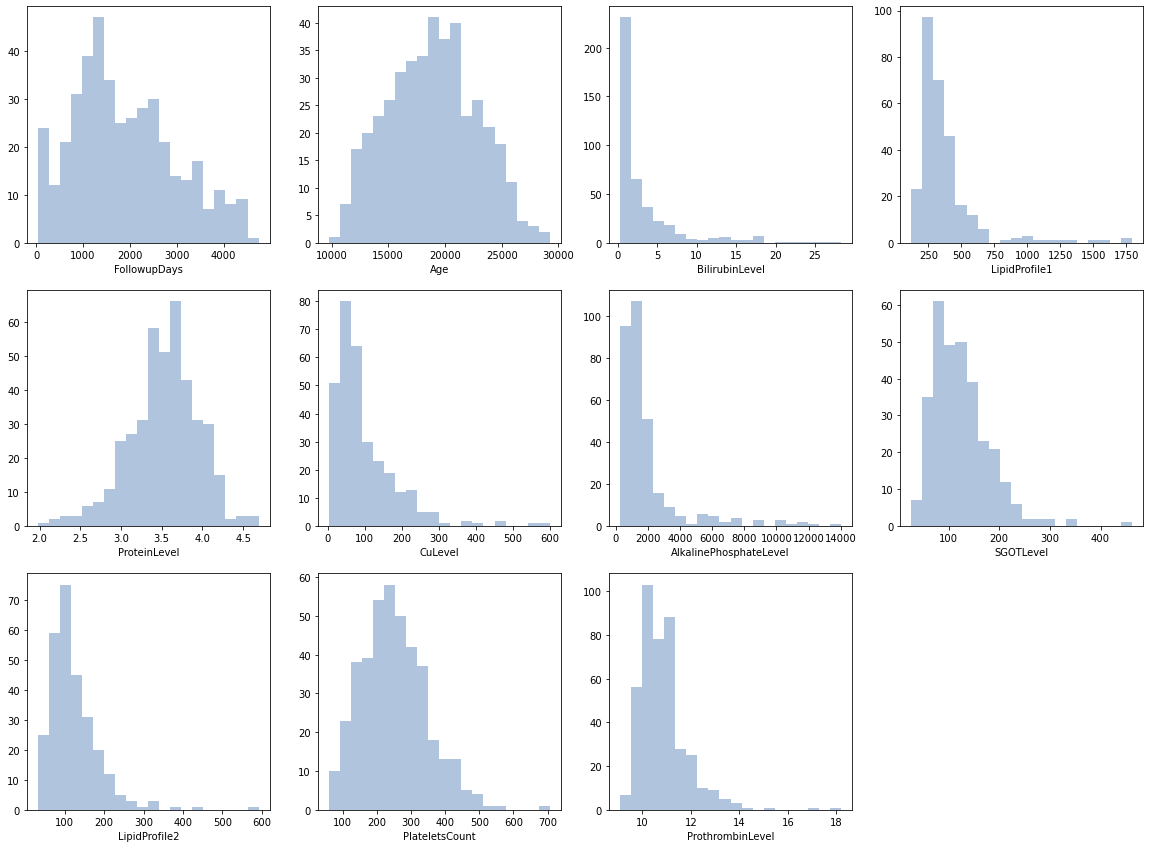

In [206]:
plt.figure(figsize = (20,20))

for i in range(1,len(num_cols)+1):
    plt.subplot(4,4,i)
    plt.hist(df[num_cols[i-1]],color = "lightsteelblue", bins = 20)
    plt.xlabel(num_cols[i-1])

We can see data is right skewed for various levels like LipidProfile1, Protein level etc.

#### Outliers

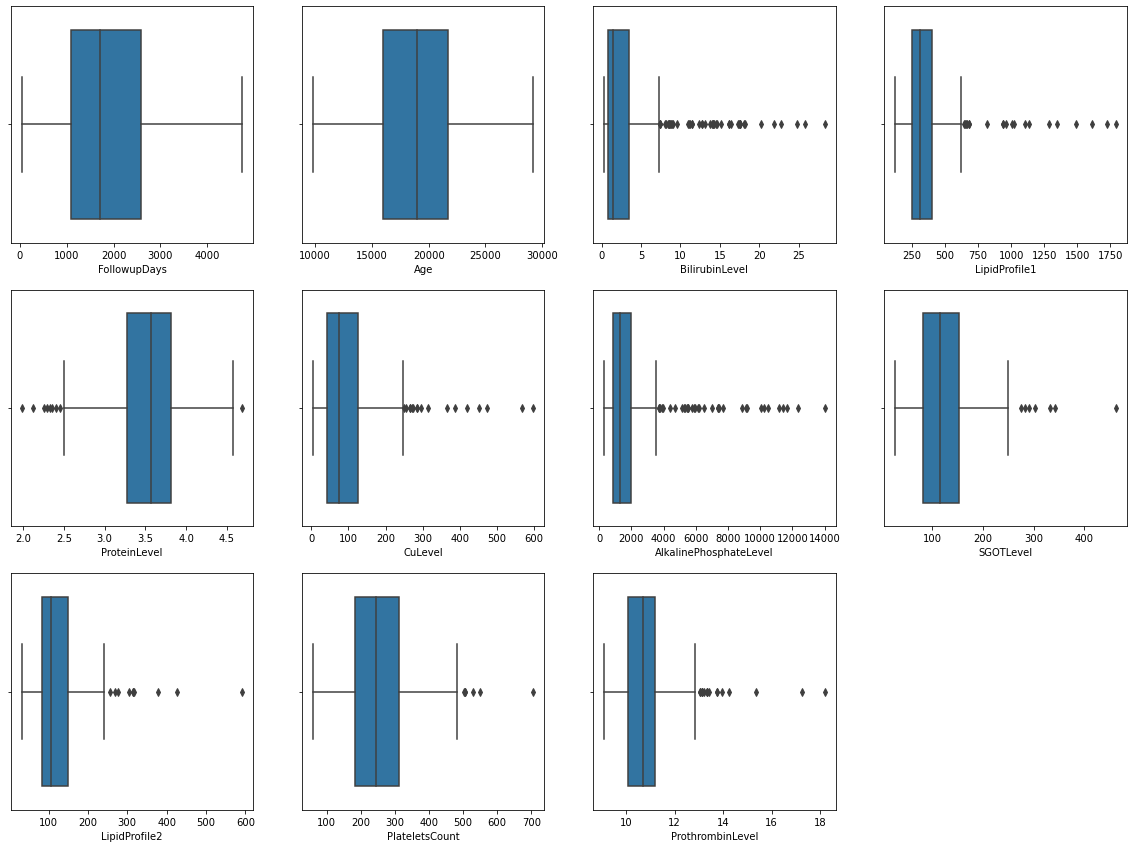

In [207]:
plt.figure(figsize = (20,20))


for i in range(1,len(num_cols)+1):
    plt.subplot(4,4,i)
    sns.boxplot(df[num_cols[i-1]])

There are outliers present in the data especially for different levels. We will be using some transformations to reduce the impact of outliers.

As of now, we will impute missing values for numerical columns with median. Later we will use KNNImputer to handle it 

In [208]:
for c in num_cols:
    df[c].fillna(df[c].median(), inplace=True)

In [209]:
df[num_cols].isnull().sum()

FollowupDays              0
Age                       0
BilirubinLevel            0
LipidProfile1             0
ProteinLevel              0
CuLevel                   0
AlkalinePhosphateLevel    0
SGOTLevel                 0
LipidProfile2             0
PlateletsCount            0
ProthrombinLevel          0
dtype: int64

#### Categorical

In [210]:
cat_cols = df.select_dtypes(include='object').columns

In [211]:
df[cat_cols].isnull().sum()

FinalStatus                    0
Medication                   106
Gender                         0
AscitesStatus                106
LiverSize                    106
SpiderAngiomas               106
FluidAccumulationSwelling      0
StageofDisease                 0
DiureticTherapy                0
dtype: int64

Creating a separate category for nulls. Instead of imputing with mode it's better to create a separate category as count is quite significant

In [212]:

df[['Medication','AscitesStatus','LiverSize','SpiderAngiomas']] = \
df[['Medication','AscitesStatus','LiverSize','SpiderAngiomas']].replace(np.nan,'NONE')

df['StageofDisease'] = df['StageofDisease'].replace('nan','NONE')

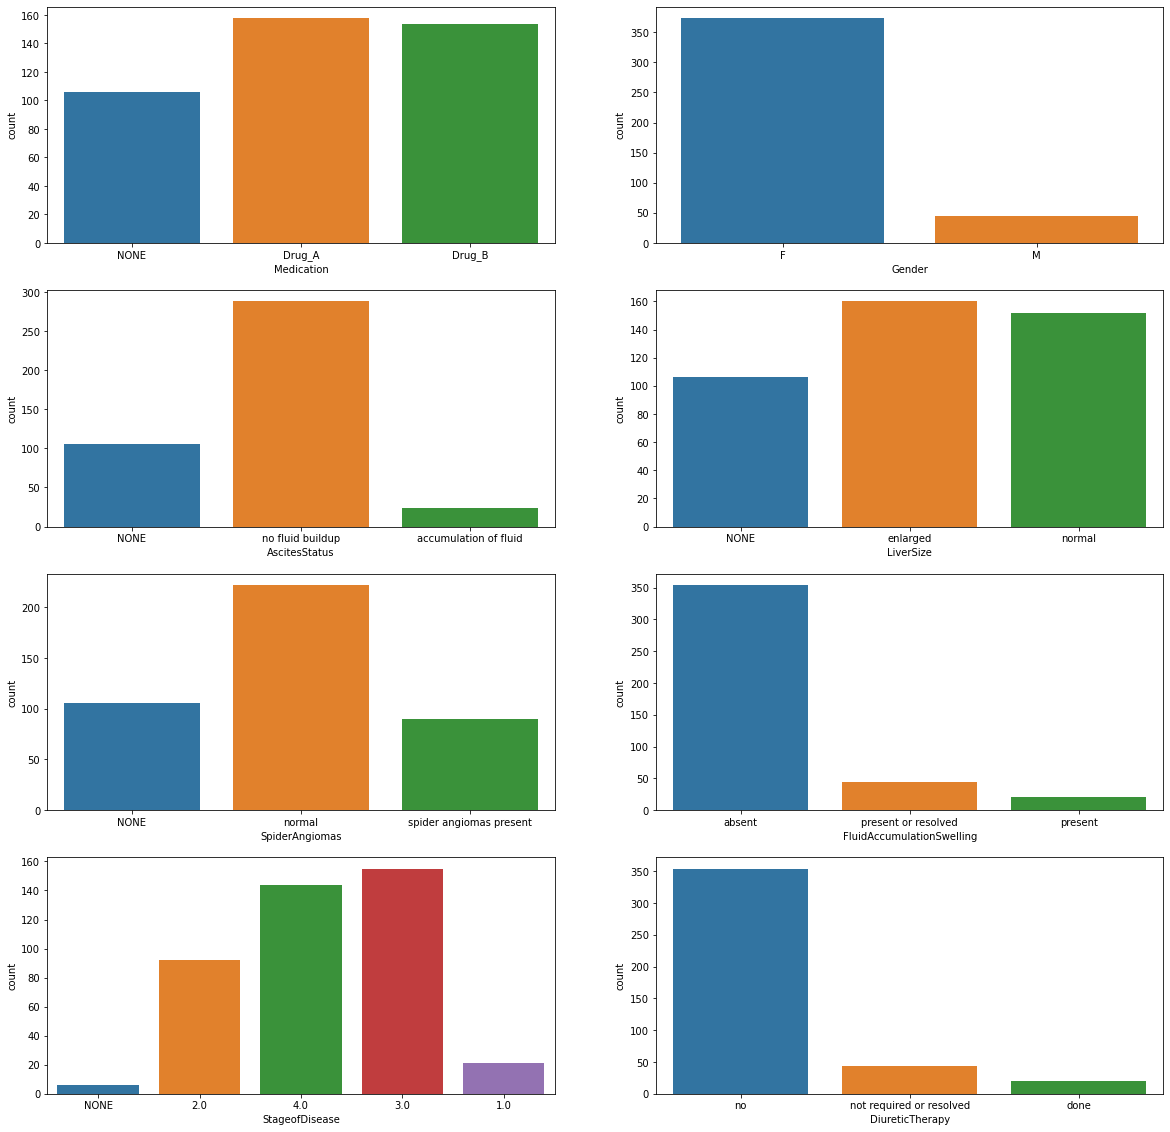

In [213]:
plt.figure(figsize = (20,20))


for i in range(1,len(cat_cols)):
    plt.subplot(4,2,i)
    sns.countplot(df[cat_cols[i]])

In [214]:
df.shape

(418, 20)

<AxesSubplot:xlabel='FinalStatus', ylabel='count'>

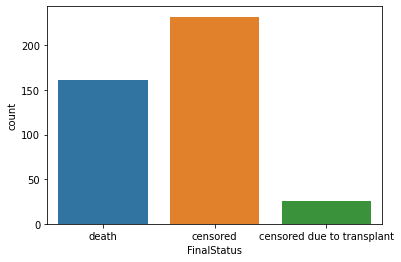

In [215]:
sns.countplot(df['FinalStatus'])

We can class imbalance for our target. We will see if we can do oversampling using techniques like SMOTE

In [216]:
df.isnull().sum()

FollowupDays                 0
FinalStatus                  0
Medication                   0
Age                          0
Gender                       0
AscitesStatus                0
LiverSize                    0
SpiderAngiomas               0
FluidAccumulationSwelling    0
BilirubinLevel               0
LipidProfile1                0
ProteinLevel                 0
CuLevel                      0
AlkalinePhosphateLevel       0
SGOTLevel                    0
LipidProfile2                0
PlateletsCount               0
ProthrombinLevel             0
StageofDisease               0
DiureticTherapy              0
dtype: int64

#### Analyzing relationship of variables with target

In [217]:
num_cols = df.select_dtypes(np.number).columns
cat_cols = df.select_dtypes(include='object').columns

In [218]:
num_cols

Index(['FollowupDays', 'Age', 'BilirubinLevel', 'LipidProfile1',
       'ProteinLevel', 'CuLevel', 'AlkalinePhosphateLevel', 'SGOTLevel',
       'LipidProfile2', 'PlateletsCount', 'ProthrombinLevel'],
      dtype='object')

In [219]:
cat_cols

Index(['FinalStatus', 'Medication', 'Gender', 'AscitesStatus', 'LiverSize',
       'SpiderAngiomas', 'FluidAccumulationSwelling', 'StageofDisease',
       'DiureticTherapy'],
      dtype='object')

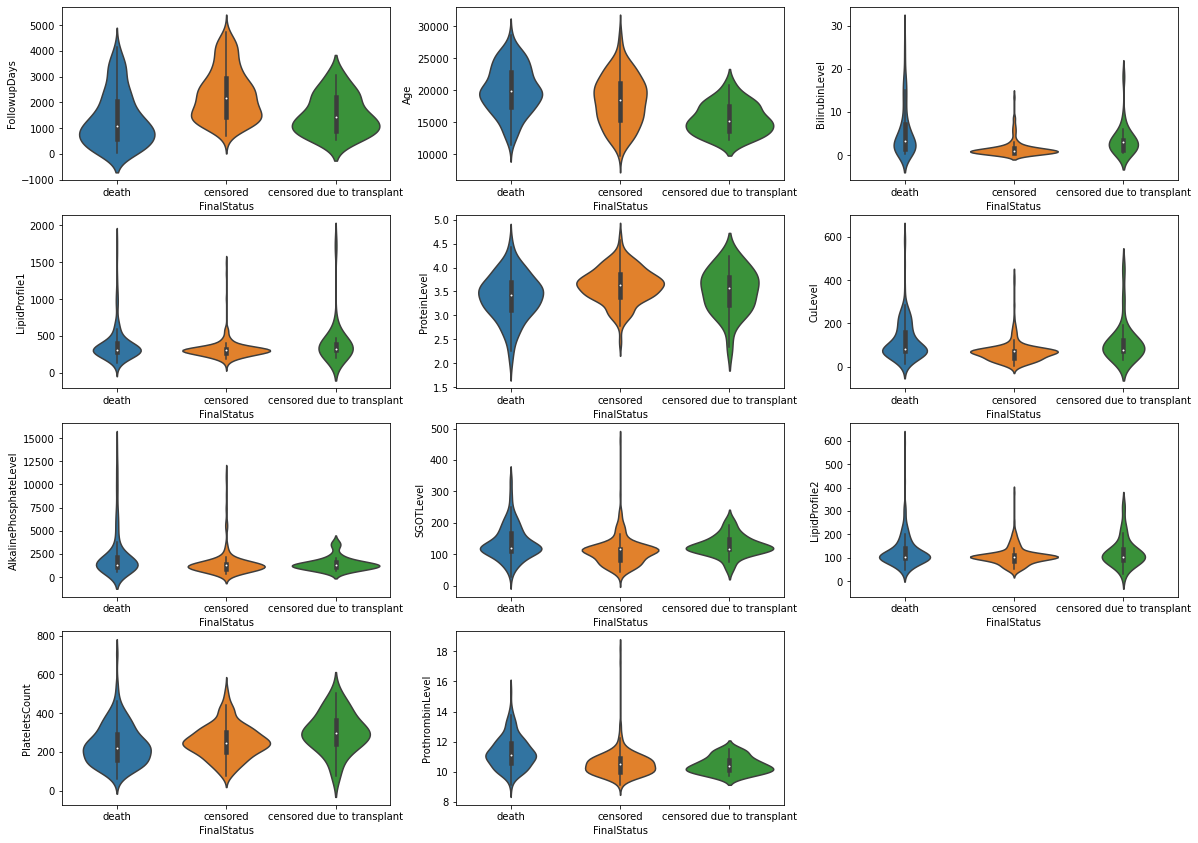

In [220]:
plt.figure(figsize = (20,30))

for i in range(1,len(num_cols)+1):
    plt.subplot(8,3,i)
    sns.violinplot(x=df['FinalStatus'],y= df[num_cols[i-1]])

plt.show()

Slight difference is observed across medians when comparing Age with FinalStatus.
For rest of the plots, there is nothing significant being observed across target.
Generally people having high BilirubinLevel/CuLevel die(FinalStatus = 'Death')

<AxesSubplot:xlabel='LiverSize'>

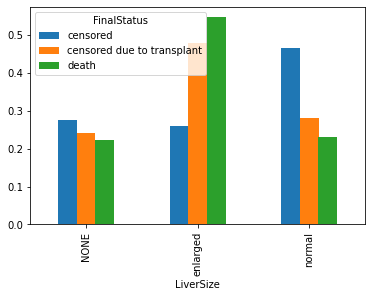

In [221]:
pd.crosstab(df['LiverSize'], df['FinalStatus'], normalize='columns').plot(kind='bar')

We can higher deaths among people having liversize as enlarged

<AxesSubplot:xlabel='SpiderAngiomas'>

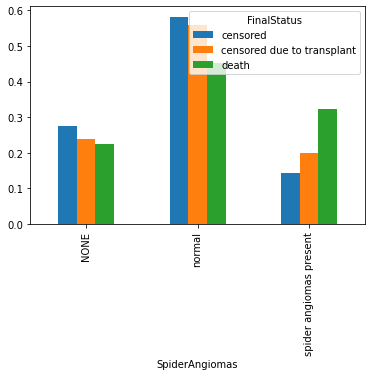

In [222]:
pd.crosstab(df['SpiderAngiomas'], df['FinalStatus'], normalize='columns').plot(kind='bar')

We can higher deaths among people having spider angiomas present

<AxesSubplot:xlabel='StageofDisease'>

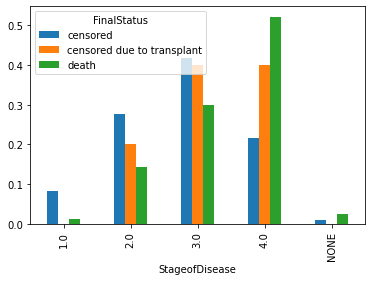

In [223]:
pd.crosstab(df['StageofDisease'], df['FinalStatus'], normalize='columns').plot(kind='bar')

As expected, higher the stage of disease higher is the chance of death

In [224]:
num_cols

Index(['FollowupDays', 'Age', 'BilirubinLevel', 'LipidProfile1',
       'ProteinLevel', 'CuLevel', 'AlkalinePhosphateLevel', 'SGOTLevel',
       'LipidProfile2', 'PlateletsCount', 'ProthrombinLevel'],
      dtype='object')

<AxesSubplot:>

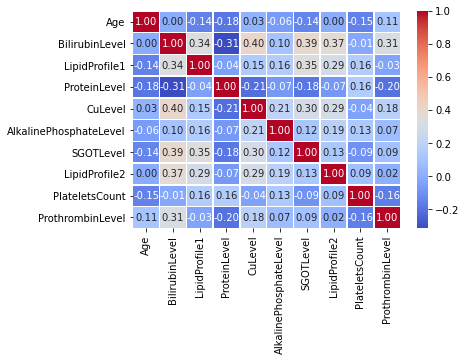

In [225]:
sns.heatmap(df[['Age', 'BilirubinLevel', 'LipidProfile1',
       'ProteinLevel', 'CuLevel', 'AlkalinePhosphateLevel', 'SGOTLevel',
       'LipidProfile2', 'PlateletsCount', 'ProthrombinLevel']].corr(),annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)

There is little to no correlation among continuous variables

## Statistical tests

In [226]:
import scipy.stats as stats

#### a) Conducting a t test to compare mean Bilirubin levels of patients with or wihout Ascites

In [227]:
# Check if the data is normal

stats.shapiro(df['BilirubinLevel'])

ShapiroResult(statistic=0.6317830085754395, pvalue=5.826841463285928e-29)

In [228]:
# pvalue < 0.05 , we can reject H0
# The data is not normal so we opt for Mann-Whitney U

In [229]:
df['AscitesStatus'].value_counts()

no fluid buildup         288
NONE                     106
accumulation of fluid     24
Name: AscitesStatus, dtype: int64

In [230]:
# Mann-Whitney U Test

# H0: Both distibutions come from the same population
# H1: Both distibutions do not come from the same population

# significance level (alpha) = 0.05

x = df[df['AscitesStatus']=="accumulation of fluid"]['BilirubinLevel']
y = df[df['AscitesStatus']=="no fluid buildup"]['BilirubinLevel']

stats.mannwhitneyu(x,y)

MannwhitneyuResult(statistic=1403.5, pvalue=6.607538898388498e-07)

In [231]:
# since pvalue < alpha, we reject H0
# We conclude that the two distibutions do not come from the same population
# The distribution of Bilirubin levels is different for people with Ascites than people not having Ascites

#### b) Conduct ANOVA analysis to determine if there is significant difference "Prothrombin" levels among different "Stages" of disease

In [232]:
stats.shapiro(df['ProthrombinLevel'])

ShapiroResult(statistic=0.8487902879714966, pvalue=1.299139497037668e-19)

In [233]:
# ANOVA

# H0: Assume all group means are equal
# H1: Assumes that at least one group mean is different from the others

In [234]:
g1 = df[df['StageofDisease'] == '1.0']['ProthrombinLevel']
g2 = df[df['StageofDisease'] == '2.0']['ProthrombinLevel']
g3 = df[df['StageofDisease'] == '3.0']['ProthrombinLevel']
g4 = df[df['StageofDisease'] == '4.0']['ProthrombinLevel']

In [235]:
stats.f_oneway(g1, g2, g3, g4)

F_onewayResult(statistic=13.56660577662565, pvalue=1.8741815323561157e-08)

In [236]:
# since pvalue < alpha, we reject H0
# We conclude that the differences between groups are statistically significant
# We conclude that there is significant differnece in Prothrombin levels for different stages of disease

#### c) Is there a significant difference between avg age of patients based on medications given

In [237]:
# Check if the data is normal
stats.shapiro(df['Age'])

ShapiroResult(statistic=0.9905691742897034, pvalue=0.008922158740460873)

In [238]:
# pvalue < 0.05 , we can reject H0
# The data is not normal so we opt for Kruskal Wallis Test

In [245]:
g1 = df[df['Medication'] == 'Drug_A']['Age']
g2 = df[df['Medication'] == 'Drug_B']['Age']
g3 = df[df['Medication'] == 'NONE']['Age']

In [249]:
g1.median(), g2.median(), g3.median()

(19347.0, 17923.5, 19745.0)

In [246]:
stats.kruskal(g1, g2, g3)

KruskalResult(statistic=11.922327902493182, pvalue=0.002576910827203199)

In [ ]:
# pvalue < 0.05 , we can reject H0
# We infer that at least at least one median is significantly different from the other group

In [254]:
# df.to_csv('disease_dataset_cleaned.csv',index=False)